In [84]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [85]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights

pre_trained_model = InceptionV3(weights='imagenet', input_shape=(160,160,3),include_top=False)


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable=False
  # Print the model summary
pre_trained_model.summary()

# Expected Output is extremely large, but should end with:

#batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
#__________________________________________________________________________________________________
#activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
#__________________________________________________________________________________________________
#mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
#                                                                 activation_276[0][0]             
#__________________________________________________________________________________________________
#concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
#                                                                 activation_280[0][0]             
#__________________________________________________________________________________________________
#activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
#__________________________________________________________________________________________________
#mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
#                                                                 mixed9_1[0][0]                   
#                                                                 concatenate_5[0][0]              
#                                                                 activation_281[0][0]             
#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 79, 79, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 79, 79, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 79, 79, 32)   0           batch_normalization_470[0][0]    
_______________________________________________________________________________________

In [86]:
last_layer = pre_trained_model.get_layer("mixed7")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 8, 8, 768)


In [87]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy',0)>0.99):
            print("\nReached 99.0% accuracy so cancelling training!")
            self.model.stop_training = True

In [88]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024,activation="relu",)(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1,activation="sigmoid")(x)           

model = Model( pre_trained_model.inputs, x) 

model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 79, 79, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 79, 79, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 79, 79, 32)   0           batch_normalization_470[0][0]    
____________________________________________________________________________________________

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_datagen =test_datagen =  ImageDataGenerator(rotation_range=20,shear_range=0.2,
                                width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,
                                 horizontal_flip=True, fill_mode="nearest")

test_datagen = test_datagen =  ImageDataGenerator(rotation_range=20,shear_range=0.2,
                                width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,
                                 horizontal_flip=True, fill_mode="nearest")


train_generator = train_datagen.flow_from_directory(
    'dataset/training', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    'dataset/test', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

Found 3586 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [90]:
callbacks = myCallback()

history = model.fit_generator(train_generator,epochs = 15,validation_data=test_generator,callbacks=[callbacks])

Epoch 1/15
113/113 [==============================] - 108s 913ms/step - loss: 134.0124 - accuracy: 0.7271 - val_loss: 27.6326 - val_accuracy: 0.7271
Epoch 2/15
113/113 [==============================] - 90s 798ms/step - loss: 14.4981 - accuracy: 0.7853 - val_loss: 1.0934 - val_accuracy: 0.7958
Epoch 3/15
113/113 [==============================] - 88s 782ms/step - loss: 1.5535 - accuracy: 0.7663 - val_loss: 0.3756 - val_accuracy: 0.8542
Epoch 4/15
113/113 [==============================] - 88s 777ms/step - loss: 0.3967 - accuracy: 0.8405 - val_loss: 0.6523 - val_accuracy: 0.7146
Epoch 5/15
113/113 [==============================] - 89s 783ms/step - loss: 0.4081 - accuracy: 0.8440 - val_loss: 0.4295 - val_accuracy: 0.8750
Epoch 6/15
113/113 [==============================] - 84s 743ms/step - loss: 0.3925 - accuracy: 0.8464 - val_loss: 0.3491 - val_accuracy: 0.8646
Epoch 7/15
113/113 [==============================] - 87s 769ms/step - loss: 0.3354 - accuracy: 0.8615 - val_loss: 0.3037 - v

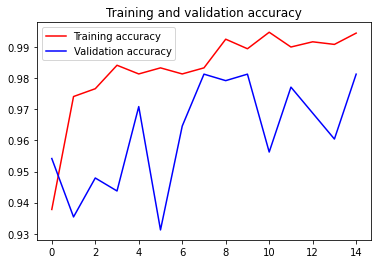

<Figure size 432x288 with 0 Axes>

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [80]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')
    np_image = transform.resize(np_image, (160, 160, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

In [82]:
from keras.preprocessing import image
def load(filename):
    img=image.load_img(filename,target_size=(160,160) )
    img=image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

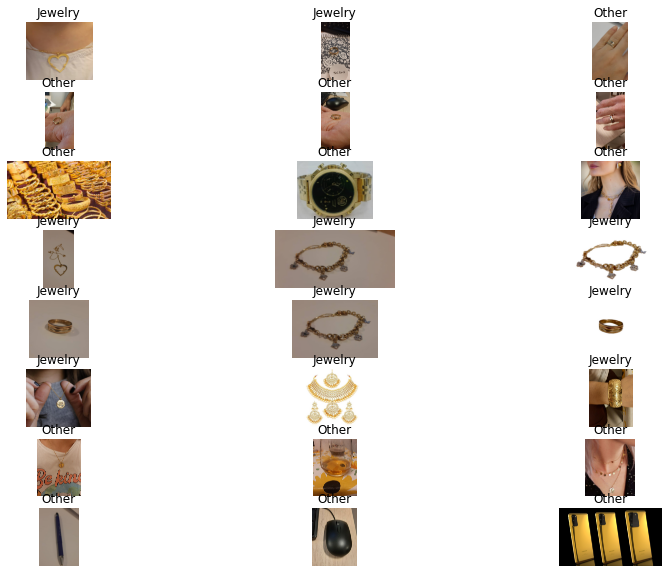

In [83]:
from PIL import Image
mypath="./test_to_show/"
from os import listdir
from os.path import isfile, join
images = [f for f in listdir(mypath) if isfile(join(mypath, f))]
count=0
plt.figure(figsize=(14, 10))
for img in images:
    test_image=Image.open(mypath+img)
    inp_org=np.array(test_image)
    #inp=np.array(test_image.resize((32,32)))
    #inp=inp
    #inp=inp.reshape((1,32,32,3))
    img = load(mypath+img)
    #classifier.predict(image)
    cls=model.predict(img)
    if np.round(cls[0])==0:
        lbl="Jewelry"
    elif np.round(cls[0])==1:
        lbl="Other"
    #plot1 = plt.figure(count)
    ax = plt.subplot(8, 3, count + 1)
    plt.imshow(inp_org)
    plt.title(lbl)
    plt.axis("off")
    count+=1
